In [1]:
!pip install dmba

In [2]:
import math
import os
import random
from pathlib import Path
from collections import defaultdict
from itertools import product


import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

from dmba import plotDecisionTree, textDecisionTree

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

%matplotlib inline

no display found. Using non-interactive Agg backend


In [3]:
loan3000 = pd.read_csv("/content/drive/MyDrive/loan3000.csv")

In [4]:
loan3000

,Unnamed: 0,outcome,purpose_,dti,borrower_score,payment_inc_ratio
0,32109,paid off,debt_consolidation,21.23,0.40,5.11135
1,16982,default,credit_card,15.49,0.40,5.43165
2,25335,paid off,debt_consolidation,27.30,0.70,9.23003
3,34580,paid off,major_purchase,21.11,0.40,2.33482
4,14424,default,debt_consolidation,16.46,0.45,12.10320
...,...,...,...,...,...,...
2995,36589,paid off,debt_consolidation,13.30,0.50,18.36620
2996,43889,paid off,other,6.09,0.60,1.80421
2997,7219,default,debt_consolidation,16.13,0.20,15.42180
2998,8987,default,debt_consolidation,18.39,0.45,8.92335


- outcome : 응답변수, 대출 모두 갚았으면 0 / 연체이면 1
- purpose_ : 대출 목적
- dti : 소득 대비 부채 비율
- borrow_score : 차용인의 신용도 (0~1 scale)
- payment_inc_ratio : 소득 대비 대출 상환 비율


In [5]:
loan_data = pd.read_csv('/content/drive/MyDrive/loan_data.csv.gz', index_col=0)
loan_data

,status,loan_amnt,term,annual_inc,dti,payment_inc_ratio,revol_bal,revol_util,purpose,home_ownership,delinq_2yrs_zero,pub_rec_zero,open_acc,grade,outcome,emp_length,purpose_,home_,emp_len_,borrower_score
1,Charged Off,2500,60 months,30000,1.00,2.39320,1687,9.4,car,RENT,1,1,3,4.8,default,1,major_purchase,RENT,> 1 Year,0.65
2,Charged Off,5600,60 months,40000,5.55,4.57170,5210,32.6,small_business,OWN,1,1,11,1.4,default,5,small_business,OWN,> 1 Year,0.80
3,Charged Off,5375,60 months,15000,18.08,9.71600,9279,36.5,other,RENT,1,1,2,6.0,default,1,other,RENT,> 1 Year,0.60
4,Charged Off,9000,36 months,30000,10.08,12.21520,10452,91.7,debt_consolidation,RENT,1,1,4,4.2,default,1,debt_consolidation,RENT,> 1 Year,0.50
5,Charged Off,10000,36 months,100000,7.06,3.90888,11997,55.5,other,RENT,1,1,14,5.4,default,4,other,RENT,> 1 Year,0.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45338,Fully Paid,8000,36 months,72000,18.97,4.57850,9725,58.2,credit_card,RENT,1,0,9,4.2,paid off,8,credit_card,RENT,> 1 Year,0.35
45339,Fully Paid,2000,36 months,25200,13.24,3.20333,4925,40.7,wedding,MORTGAGE,0,1,13,4.2,paid off,3,other,MORTGAGE,> 1 Year,0.50
45340,Fully Paid,4375,36 months,20000,7.95,9.98460,6574,73.0,debt_consolidation,MORTGAGE,1,1,8,2.4,paid off,1,debt_consolidation,MORTGAGE,> 1 Year,0.55
45341,Fully Paid,8000,36 months,48000,26.91,6.45250,10303,32.4,debt_consolidation,MORTGAGE,1,1,10,5.2,paid off,1,debt_consolidation,MORTGAGE,> 1 Year,0.65


## **1. XG부스트**

In [6]:
# xgboost 모델
predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

X = loan3000[predictors]
y = pd.Series([1 if o == 'default' else 0 for o in loan3000[outcome]])

xgb = XGBClassifier(objective='binary:logistic', subsample=.63, 
                    use_label_encoder=False, eval_metric='error')
print(xgb.fit(X, y))

XGBClassifier(eval_metric='error', subsample=0.63, use_label_encoder=False)


- object : 문제가 어떤 종류인지 설정
- subsample : 각 반복 구간마다 샘플링할 입력 데이터의 비율 조정
- eval_metric : 오류를 측정할 평가 지표 설정

In [7]:
# 예측 확률 print
xgb_df = X.copy()
xgb_df['prediction'] = ['default' if p == 1 else 'paid off' for p in xgb.predict(X)]
xgb_df['prob_default'] = xgb.predict_proba(X)[:, 0]
print(xgb_df.head())

   borrower_score  payment_inc_ratio prediction  prob_default
0            0.40            5.11135   paid off      0.560805
1            0.40            5.43165    default      0.442436
2            0.70            9.23003   paid off      0.684751
3            0.40            2.33482   paid off      0.538130
4            0.45           12.10320    default      0.369834


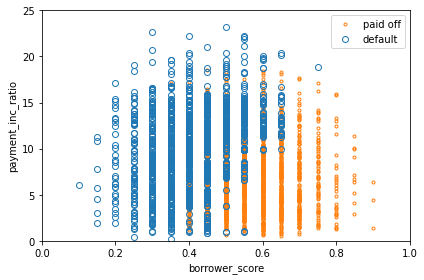

In [8]:
# 대출 데이터에 대한 XG부스트의 예측 결과 그래프
fig, ax = plt.subplots(figsize=(6, 4))

xgb_df.loc[xgb_df.prediction=='paid off'].plot(
    x='borrower_score', y='payment_inc_ratio', style='.', 
    markerfacecolor='none', markeredgecolor='C1', ax=ax)
xgb_df.loc[xgb_df.prediction=='default'].plot(
    x='borrower_score', y='payment_inc_ratio', style='o', 
    markerfacecolor='none', markeredgecolor='C0', ax=ax)
ax.legend(['paid off', 'default']);
ax.set_xlim(0, 1)
ax.set_ylim(0, 25)
ax.set_xlabel('borrower_score')
ax.set_ylabel('payment_inc_ratio')

plt.tight_layout()
plt.show()

- 전체적으로 랜덤 포레스트를 이용했을 때와 비슷한 결과
- 예측 결과가 다소 복잡하고, 가끔 신용점수가 높은 경우인데도 예측 결과가 연체(default)로 나오기도 함

## **2. 정규화 : 오버피팅 피하기**

In [9]:
predictors = ['loan_amnt', 'term', 'annual_inc', 'dti', 
              'payment_inc_ratio', 'revol_bal', 'revol_util', 
              'purpose', 'delinq_2yrs_zero', 'pub_rec_zero', 
              'open_acc', 'grade', 'emp_length', 'purpose_', 
              'home_', 'emp_len_', 'borrower_score']
outcome = 'outcome'

X = pd.get_dummies(loan_data[predictors], drop_first=True)
y = pd.Series([1 if o == 'default' else 0 for o in loan_data[outcome]])

# 학습 / 검증 데이터 분리
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=10000)

# XGB 모델(기본) 학습
xgb_default = XGBClassifier(objective='binary:logistic', n_estimators=250, max_depth=6,
                            reg_lambda=0, learning_rate=0.3, subsample=1,
                            use_label_encoder=False, eval_metric='error')
xgb_default.fit(train_X, train_y)

# XGB 모델(페널티 부가) 학습
xgb_penalty = XGBClassifier(objective='binary:logistic', n_estimators=250, max_depth=6,
                            reg_lambda=1000, learning_rate=0.1, subsample=0.63,
                            use_label_encoder=False, eval_metric='error')
print(xgb_penalty.fit(train_X, train_y))

XGBClassifier(eval_metric='error', max_depth=6, n_estimators=250,
              reg_lambda=1000, subsample=0.63, use_label_encoder=False)


- 전체 데이터 가운데 랜덤하게 테스트를 위한 10000개 데이터 선별 ➡ 나머지 데이터는 학습 데이터로 사용
- subsample, learning_rate 사용하여 오버피팅 방지
- reg_lambda 사용하여 L2-regrularization 적용

In [10]:
# 결과 확인
pred_default = xgb_default.predict_proba(train_X)[:, 1]
error_default = abs(train_y - pred_default) > 0.5
print('default (train): ', np.mean(error_default))

pred_default = xgb_default.predict_proba(valid_X)[:, 1]
error_default = abs(valid_y - pred_default) > 0.5
print('default: ', np.mean(error_default))

pred_penalty = xgb_penalty.predict_proba(valid_X)[:, 1]
error_penalty = abs(valid_y - pred_penalty) > 0.5
print('penalty: ', np.mean(error_penalty))

default (train):  0.11813140173165072
default:  0.3608
penalty:  0.3386


- 학습 데이터에 대한 오차율 = 12.4%
- 테스트 데이터에 대한 오차율 = 35.5%
- **정규화 적용 모델의 오차율 = 32.9%**

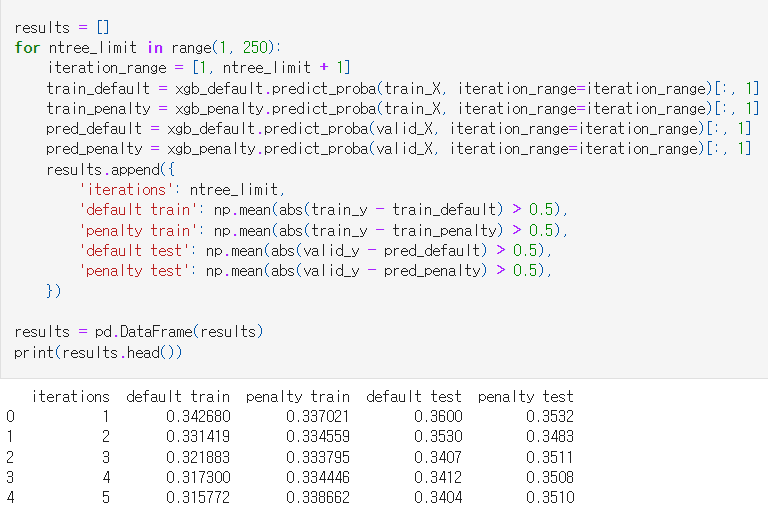

- 예측 확률 print

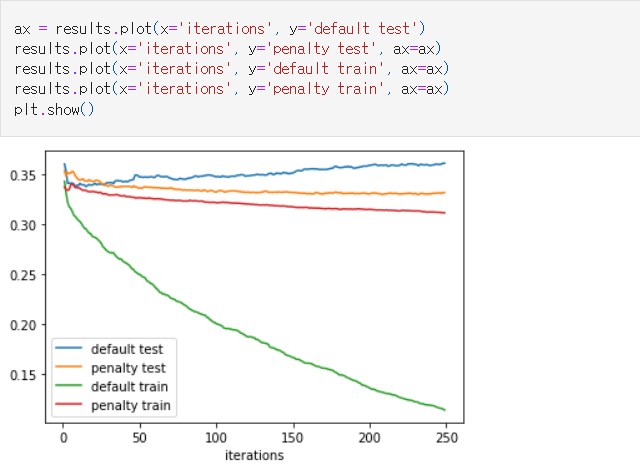

- 반복 횟수에 따른 오차율 그래프
- 기본 모형은 정확도가 학습 데이터에 대해서는 꾸준히 좋아지지만 테스트 데이터에 대해서는 나빠진다. 벌점을 추가한 모형은 그렇지 않다!

## **3. 하이퍼파라미터와 교차타당성검사**
- 5개의 폴드를 이용해 각 폴드마다 각 모델에 대한 오차 계산
- 가능한 모든 하이퍼파라미터 조합을 만들고, 각 조합으로 모델을 피팅 후 평가

In [11]:
idx = np.random.choice(range(5), size=len(X), replace=True)
error = []
for eta, max_depth in product([0.1, 0.5, 0.9], [3, 6, 9]):
    xgb = XGBClassifier(objective='binary:logistic', n_estimators=250, 
                        max_depth=max_depth, learning_rate=eta,
                        use_label_encoder=False, eval_metric='error')
    cv_error = []
    for k in range(5):
        fold_idx = idx == k
        train_X = X.loc[~fold_idx]; train_y = y[~fold_idx]
        valid_X = X.loc[fold_idx]; valid_y = y[fold_idx]

        xgb.fit(train_X, train_y)
        pred = xgb.predict_proba(valid_X)[:, 1]
        cv_error.append(np.mean(abs(valid_y - pred) > 0.5))
    error.append({
        'eta': eta,
        'max_depth': max_depth,
        'avg_error': np.mean(cv_error)
    })
    print(error[-1])
errors = pd.DataFrame(error)
print(errors)

{'eta': 0.1, 'max_depth': 3, 'avg_error': 0.3289217778298635}
{'eta': 0.1, 'max_depth': 6, 'avg_error': 0.3355475576821358}
{'eta': 0.1, 'max_depth': 9, 'avg_error': 0.34200507359012133}
{'eta': 0.5, 'max_depth': 3, 'avg_error': 0.3384277362600506}
{'eta': 0.5, 'max_depth': 6, 'avg_error': 0.36803152147481005}
{'eta': 0.5, 'max_depth': 9, 'avg_error': 0.3704037756213792}
{'eta': 0.9, 'max_depth': 3, 'avg_error': 0.3535393098115921}
{'eta': 0.9, 'max_depth': 6, 'avg_error': 0.3895588357210377}
{'eta': 0.9, 'max_depth': 9, 'avg_error': 0.38266842312670113}
   eta  max_depth  avg_error
0  0.1          3   0.328922
1  0.1          6   0.335548
2  0.1          9   0.342005
3  0.5          3   0.338428
4  0.5          6   0.368032
5  0.5          9   0.370404
6  0.9          3   0.353539
7  0.9          6   0.389559
8  0.9          9   0.382668


In [12]:
print(errors.pivot_table(index='eta', columns='max_depth', values='avg_error') * 100)

max_depth          3          6          9
eta                                       
0.1        32.892178  33.554756  34.200507
0.5        33.842774  36.803152  37.040378
0.9        35.353931  38.955884  38.266842


- 다른 파라미터 조합 간의 오차율 비교
- 교차타당성 검사를 통해 **learning_rate 값이 작으면서** **깊이가 얕은 트리**를 사용하는 것이 더 정확한 성능을 보인다는 사실을 알게 되었다.
